In [106]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [107]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [108]:
plt.ion()
plt.style.use('seaborn-colorblind')

In [109]:
conn = sqlite3.connect('sql/sql.db')
cursor = conn.cursor()

In [110]:
#Executar só uma vez a cada vez que abrir o colab
f = io.open('sql/trabalho.sql', 'r', encoding='ISO-8859-1')
sql = f.read()
cursor.executescript(sql)

OperationalError: table ANSWERS already exists

Modelo relacional
<img src="diagrama/diagrama.png">

In [111]:
def boostreap(p,n_size = 500):
    values = np.zeros(n_size)
    
    d = pd.DataFrame(p)
    
    for i in range(n_size):
        sample = d[0].sample(replace = True,n = len(p))
        values[i] = sample.mean()
        
    return values

In [112]:
def gerarB(selecionados,df,n_size=500):
    p = np.zeros(0)
    for country in selecionados:
        pais = df[df["COUNTRYCODE"] == country]

        for x in range(pais.shape[0]):
            sample = pais.iloc[x]
            
            new = np.ones(int(sample["TAMANHO"])) * sample["VALUE"]
            
            p = np.concatenate((p,new))
            
            
    b = boostreap(p,n_size=n_size)
    
    return b

In [113]:
def plot_paises(i,df):
    data = df.groupby("COUNTRYCODE").mean()
    x = data['PESO'] / data['TAMANHO']    
    y = data[i]
    n = [rt2[i] for i in data.index]
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    
    model = LinearRegression()
    model.fit([[i] for i in x],y)
    
    linha = [[x.min()],[x.max()]]
    y_pred = model.predict(linha)
    plt.plot(linha,y_pred)
    
    for j, txt in enumerate(n):
        ax.annotate(txt, (x[j], y[j]))

In [114]:
rt2 = {0: 'Austria',
 1: 'Belgium',
 2: 'Bulgaria',
 13: 'Croatia',
 3: 'Cyprus',
 4: 'Czech Rep',
 6: 'Denmark',
 7: 'Estonia',
 9: 'Finland',
 10: 'France',
 5: 'Germany',
 11: 'Great Britain',
 12: 'Greece',
 14: 'Hungary',
 15: 'Ireland',
 16: 'Italy',
 19: 'Latvia',
 17: 'Lithuania',
 18: 'Luxembourg',
 20: 'Malta',
 21: 'Netherlands',
 22: 'Poland',
 23: 'Portugal',
 24: 'Romania',
 27: 'Slovak Rep',
 26: 'Slovenia',
 8: 'Spain',
 25: 'Sweden'}

# Questão 2: Existe uma relação entre o aumento do IDH do país e a maior sensação de segurança?

In [115]:
query = """
Select *
From PESOS NATURAL JOIN ANSWERS NATURAL JOIN SIZE NATURAL JOIN IDH NATURAL JOIN Country
WHERE SUBSET == TIPO

"""

df = pd.read_sql_query(query,conn)
df["TAMANHO"] = df["PERCENTAGE"] * df["VALOR"] * 0.01
df["PESO"] = df["TAMANHO"] * df["VALUE"]
df

,QC,ANSWER,VALUE,COUNTRYCODE,SUBSET,PERCENTAGE,NOTES,TIPO,VALOR,HDI,LEB,EYS,MYS,GNI,GNI_HDI,COUNTRY,TAMANHO,PESO
0,e1,Yes,0.0,0,LESBIAN,33,NULL,LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,144.21,0.000
1,e1,No,1.0,0,LESBIAN,53,NULL,LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,231.61,231.610
2,e1,Don`t know,0.5,0,LESBIAN,2,[0],LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,8.74,4.370
3,e1,Yes,0.0,0,GAY,51,NULL,GAY,1558,885.0,81.4,15.7,10.8,43.869,-5.0,AT,794.58,0.000
4,e1,No,1.0,0,GAY,25,NULL,GAY,1558,885.0,81.4,15.7,10.8,43.869,-5.0,AT,389.50,389.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,fb2_6,More perpetrators,0.0,11,BIM,65,NULL,BIM,294,907.0,80.7,16.2,13.1,39.267,9.0,GB,191.10,0.000
4704,fb2_6,Don`t know,0.5,11,BIM,3,[0],BIM,294,907.0,80.7,16.2,13.1,39.267,9.0,GB,8.82,4.410
4705,fb2_6,Alone,1.0,11,TRANS,31,NULL,TRANS,813,907.0,80.7,16.2,13.1,39.267,9.0,GB,252.03,252.030
4706,fb2_6,More perpetrators,0.0,11,TRANS,65,NULL,TRANS,813,907.0,80.7,16.2,13.1,39.267,9.0,GB,528.45,0.000


In [116]:
query = """
Select *
From IDH
"""

ref = pd.read_sql_query(query,conn)
idh = ref.columns[1:]

In [117]:
def separar(df,by,column = "COUNTRYCODE",n_size=50):
    indx = list(df.groupby(column).mean().sort_values(by).index)
    meio = int(len(indx)/2)

    maus = indx[:meio]
    bons = indx[meio:]
    
    print(by)
    
    print("Vermelho:",end="")
    
    for i in maus:
        c = df[df["COUNTRYCODE"] == i]["COUNTRY"].values[0]
        
        print(" {}".format(c),end = "")
        
    print()
    
    print("Verde:",end="")
    
    for i in bons:
        c = df[df["COUNTRYCODE"] == i]["COUNTRY"].values[0]
        
        print(" {}".format(c),end = "")
        
    print()
    
    bonsB = gerarB(bons,df,n_size=n_size)
    mausB = gerarB(maus,df,n_size=n_size)
    
    return [mausB,bonsB]

In [118]:
df

,QC,ANSWER,VALUE,COUNTRYCODE,SUBSET,PERCENTAGE,NOTES,TIPO,VALOR,HDI,LEB,EYS,MYS,GNI,GNI_HDI,COUNTRY,TAMANHO,PESO
0,e1,Yes,0.0,0,LESBIAN,33,NULL,LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,144.21,0.000
1,e1,No,1.0,0,LESBIAN,53,NULL,LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,231.61,231.610
2,e1,Don`t know,0.5,0,LESBIAN,2,[0],LESBIAN,437,885.0,81.4,15.7,10.8,43.869,-5.0,AT,8.74,4.370
3,e1,Yes,0.0,0,GAY,51,NULL,GAY,1558,885.0,81.4,15.7,10.8,43.869,-5.0,AT,794.58,0.000
4,e1,No,1.0,0,GAY,25,NULL,GAY,1558,885.0,81.4,15.7,10.8,43.869,-5.0,AT,389.50,389.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,fb2_6,More perpetrators,0.0,11,BIM,65,NULL,BIM,294,907.0,80.7,16.2,13.1,39.267,9.0,GB,191.10,0.000
4704,fb2_6,Don`t know,0.5,11,BIM,3,[0],BIM,294,907.0,80.7,16.2,13.1,39.267,9.0,GB,8.82,4.410
4705,fb2_6,Alone,1.0,11,TRANS,31,NULL,TRANS,813,907.0,80.7,16.2,13.1,39.267,9.0,GB,252.03,252.030
4706,fb2_6,More perpetrators,0.0,11,TRANS,65,NULL,TRANS,813,907.0,80.7,16.2,13.1,39.267,9.0,GB,528.45,0.000


HDI
Vermelho: BG RO HR LV HU PT MT LT PL SK CY EE GR CZ
Verde: IT ES SI FI AT FR BE LU GB SE DE IE NL DK


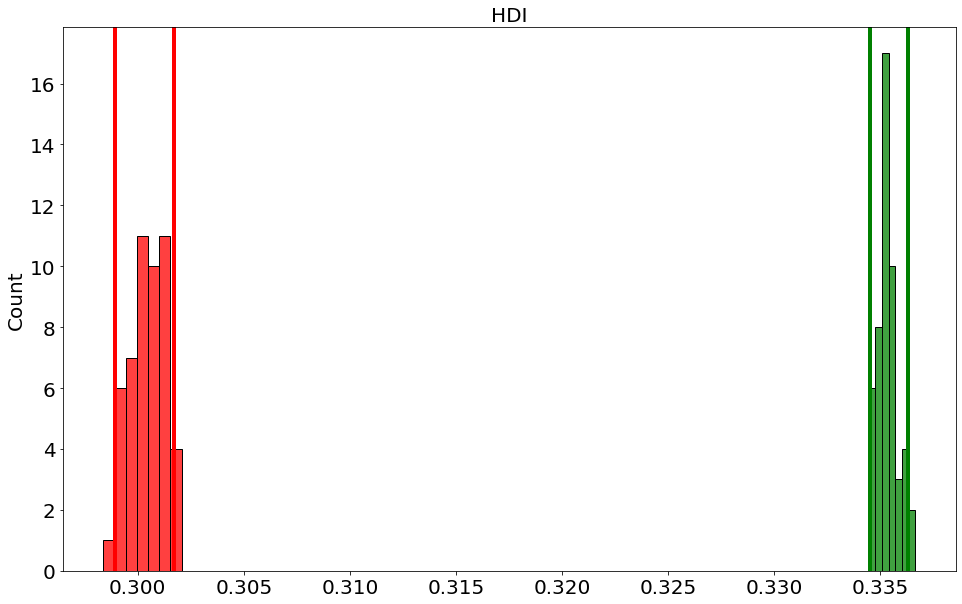

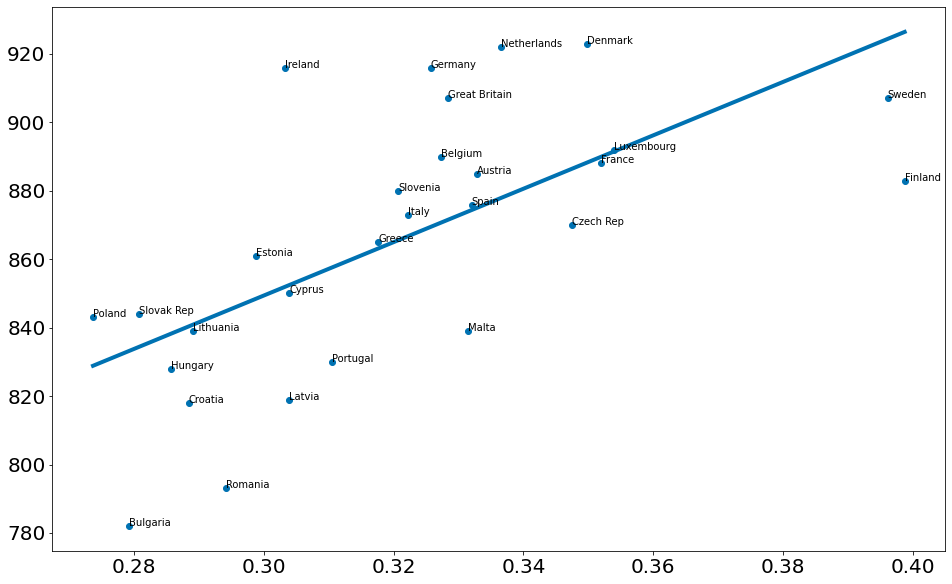

LEB
Vermelho: LT LV BG RO HU SK EE HR PL CZ CY DK SI MT
Verde: GB FI BE GR DE IE PT AT NL LU FR SE ES IT


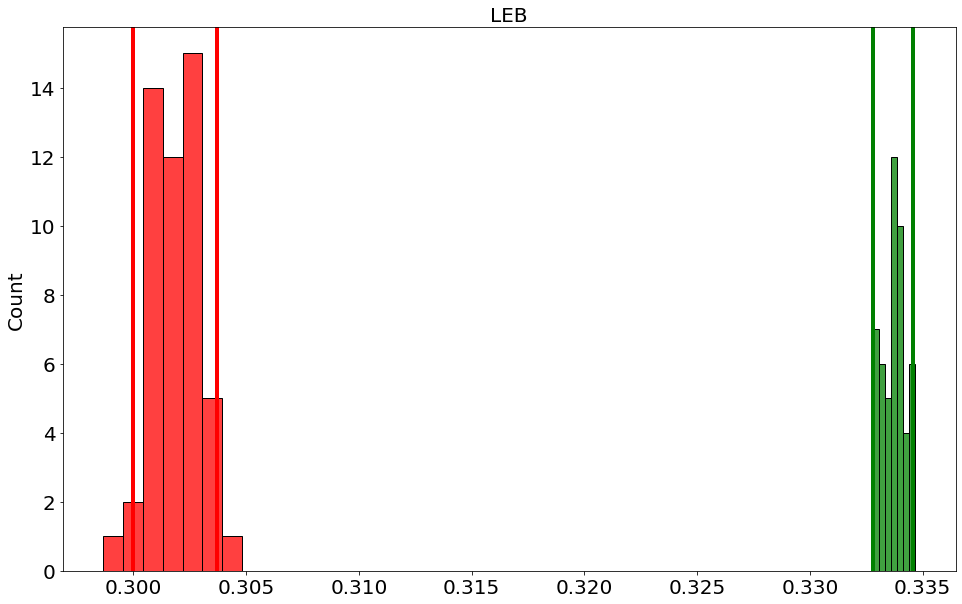

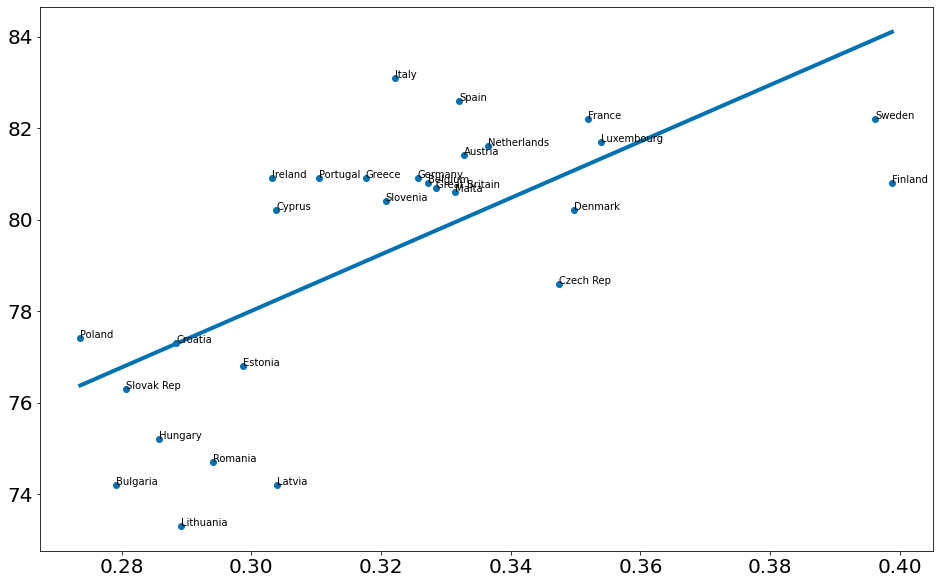

EYS
Vermelho: LU CY RO MT BG HR SK LV HU PL AT SE FR IT
Verde: GB PT BE LT CZ DE EE SI FI ES GR NL IE DK


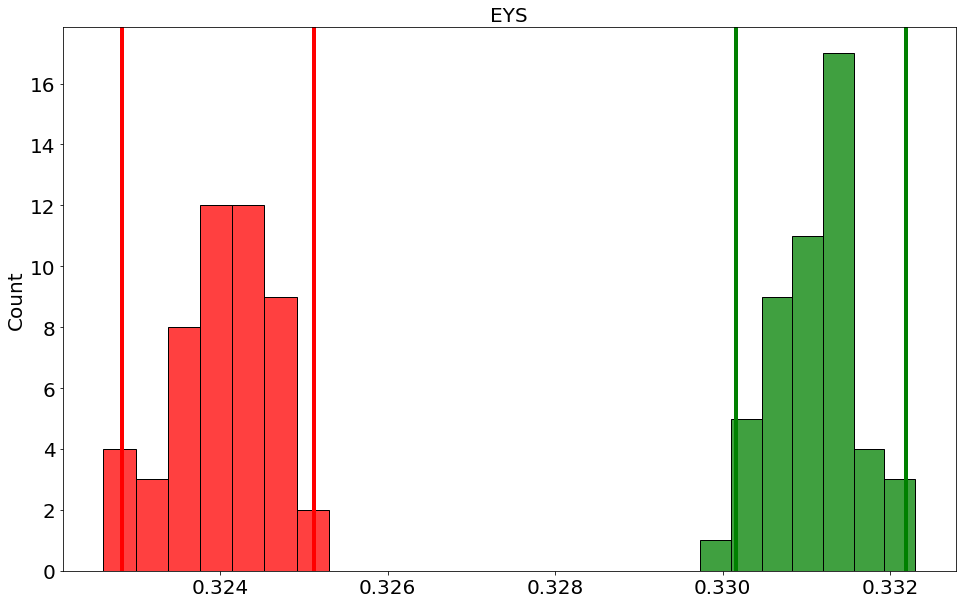

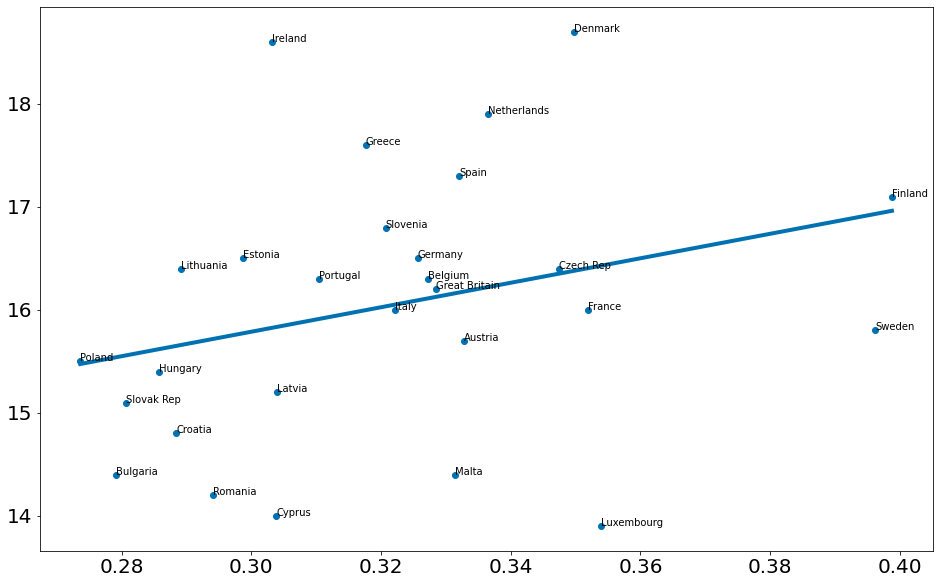

MYS
Vermelho: PT ES IT GR FI MT BG AT RO HR FR BE LV HU
Verde: CY LU PL SI NL SE IE SK CZ LT EE DK DE GB


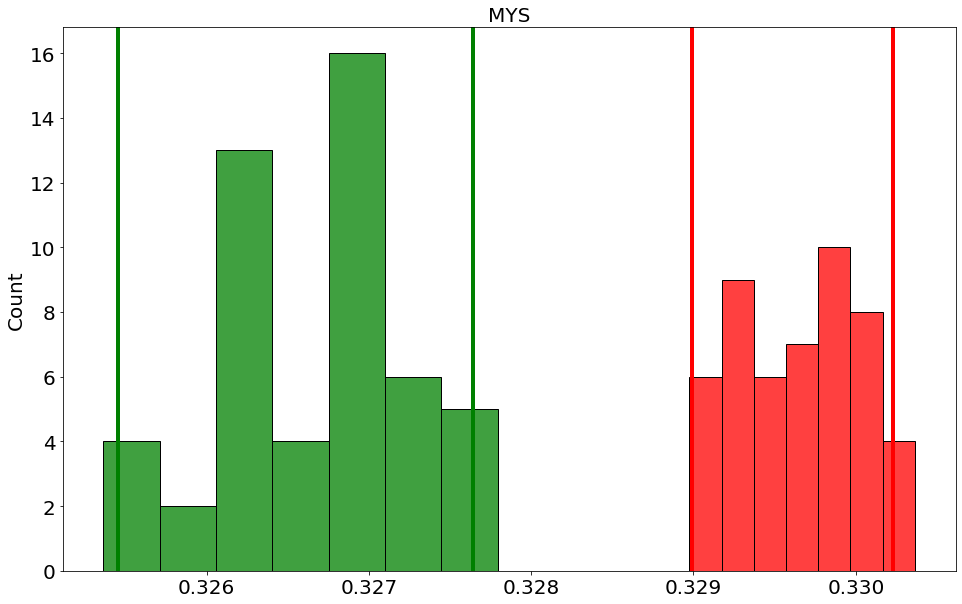

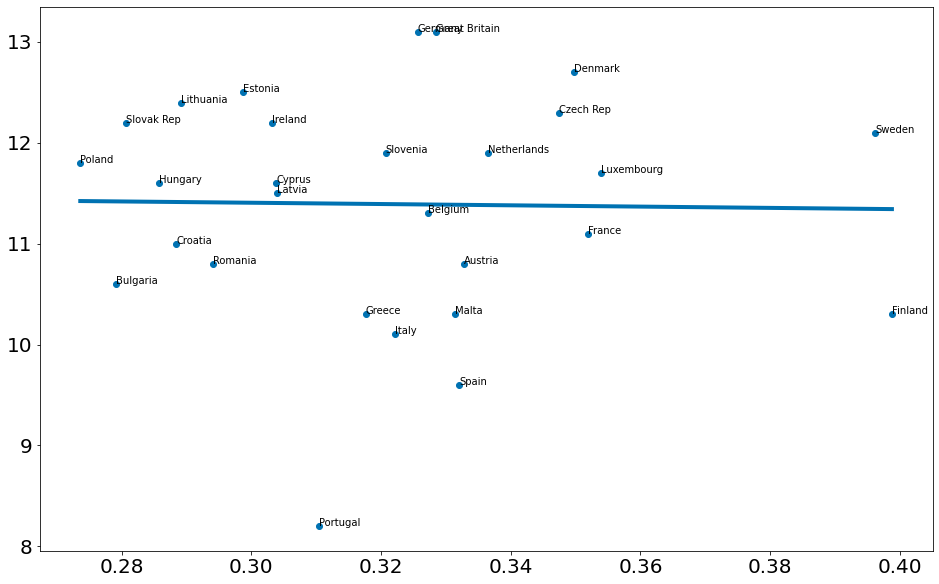

GNI
Vermelho: BG RO HR LV HU PL LT GR EE PT SK CZ SI MT
Verde: CY ES IT FR FI GB IE BE AT DE DK NL SE LU


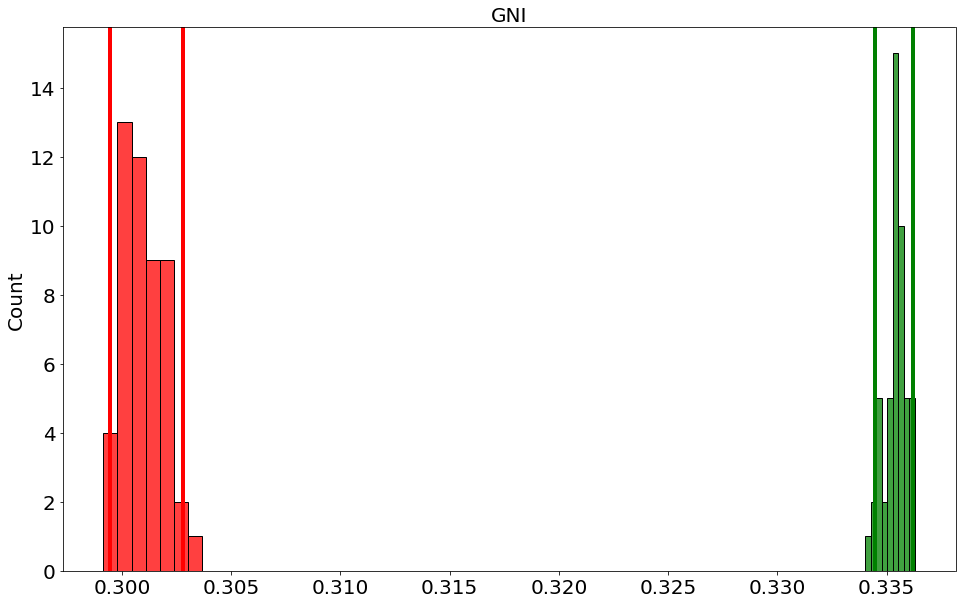

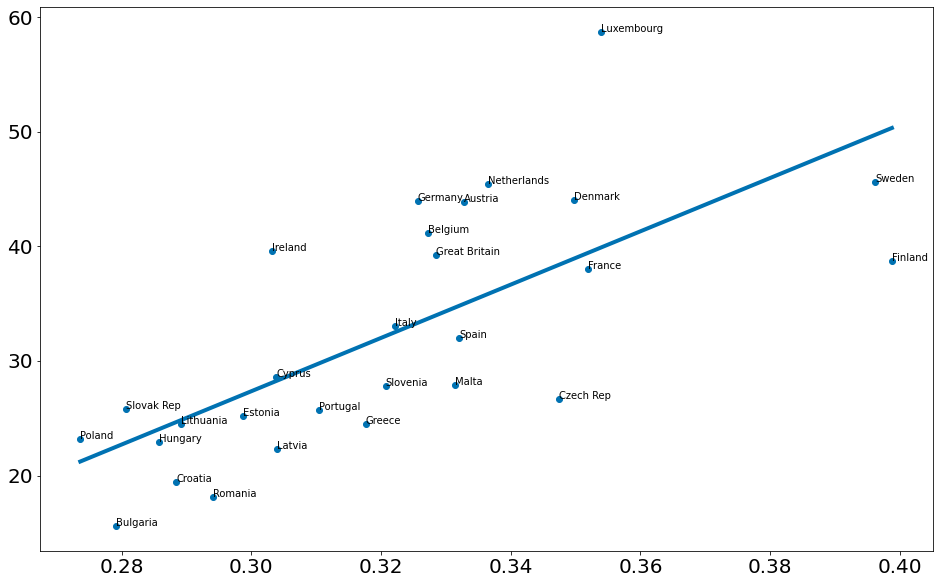

GNI_HDI
Vermelho: LU AT PT SE MT BE FI CY HU LV IT FR SK ES
Verde: LT GB NL PL CZ RO DK DE HR SI EE BG GR IE


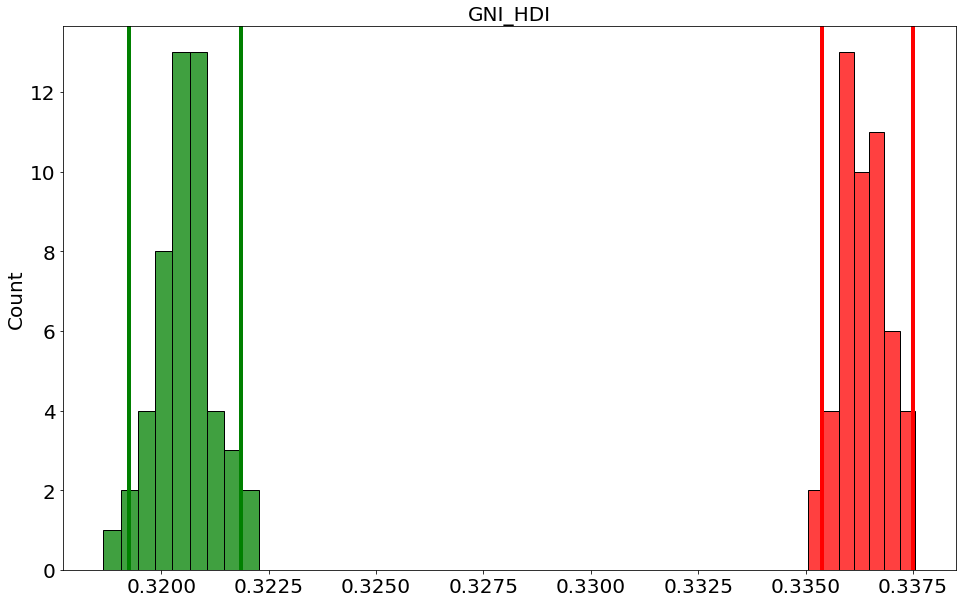

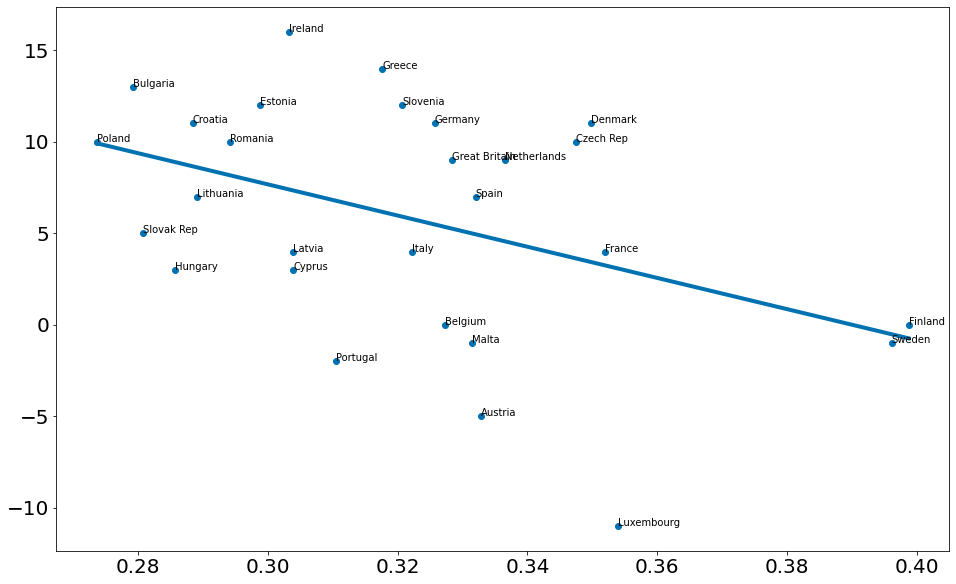

In [119]:
for i in idh:
    mausB,bonsB = separar(df,i)
    
    sns.histplot(bonsB,color="g")
    inf = np.percentile(bonsB,2.5)
    sup = np.percentile(bonsB,97.5)
    plt.axvline(inf,color="g")
    plt.axvline(sup,color="g")

    sns.histplot(mausB,color="r")
    inf = np.percentile(mausB,2.5)
    sup = np.percentile(mausB,97.5)
    plt.axvline(inf,color="r")
    plt.axvline(sup,color="r")
    
    plt.title(i)
    plt.show()
    
    plot_paises(i,df)
    plt.show()